# [E-06-Mini Project] Time Series Classification
###### 온라인 코어 2기 박수경   
#### 목표  
- Objective 1 : 시계열 데이터의 정상화(stationarization)  
- Objective 2 : 분류 모델 성능 개선

## 1. 시계열 데이터 정상화

### 1) 라이브러리와 데이터 불러오기

In [1]:
# 라이브러리 불러오기 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# air passengers 데이터 불러오기
ap = pd.read_csv('~/aiffel/Exploration/E06_Mini/data/AirPassengers.csv')


In [3]:
ap.drop('Month', axis = 1, inplace = True)

일정한 시간간격 (1달)을 기준으로 데이터가 있고, 우리는 시간에 따른 승객 수를 다룰 것이기 때문에 'Month'열을 삭제한다.

In [4]:
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


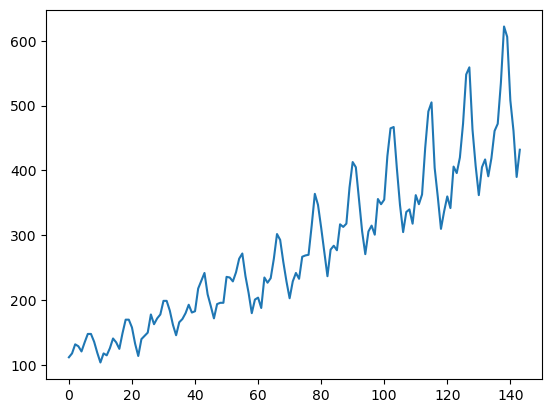

In [5]:
plt.figure()
plt.plot(ap)
plt.show()

시간에 따른 승객 수를 그래프로 나타내었다. 전체적으로 시간에 따라 증가하는 추세가 확인되며, 대강 보기에는 시즈널리티가 있는 것 같다. 분산도 점점 커지고 있다. 시계열 데이터는 정상화하는 과정이 필요하므로 로그변환과 차분을 통해 데이터를 다듬는다.

### 2) 분산을 일정하게 만들기 - log transformation

In [6]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap)

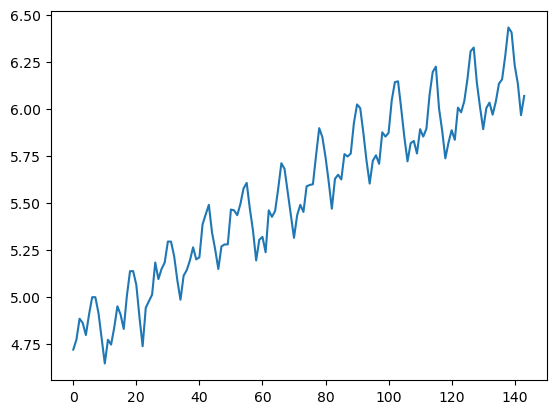

In [7]:
 
# 분산이 일정해진 것을 눈으로 확인할 수 있음
plt.figure()
plt.plot(log_transformed)
plt.show()

![](data\mini1.png)

로그 변환을 통해 분산이 일정해진 것을 확인했다.

### 3) 차분을 통해 추세 제거하기

In [8]:
# diff() 함수를 통해 간단하게 차분을 수행할 수 있음
diffed = log_transformed.diff()[1:]

데이터의 값이 일정한 비율이나 규칙성으로 증가한다면 차분하여 연이은 관측값의 차이 자체의 규칙성을 확인한다.

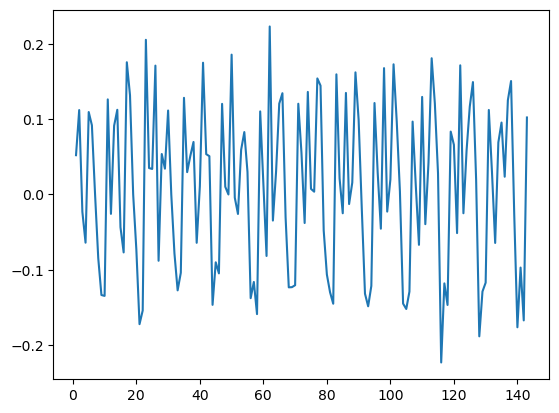

In [9]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있다
plt.figure()
plt.plot(diffed)
plt.show()

### 4) 계절 차분을 통해 계절성 제거하기

In [10]:
seasonally_diffed = diffed.diff(12) # diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있음


In [11]:
seasonally_diffed # 아래 데이터는 dropna를 적용하기 전 데이터의 형태. 살펴보기 위해 먼저 확인

,#Passengers
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


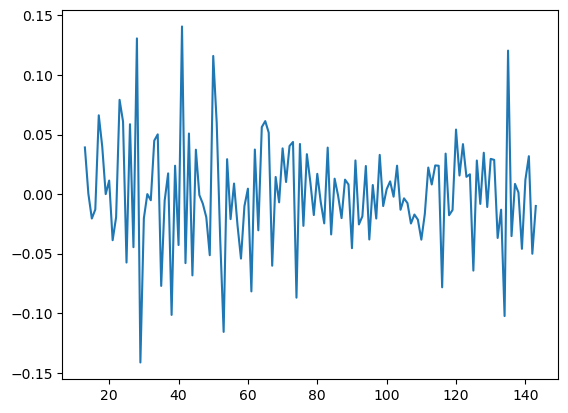

In [12]:
# 계절차분 수행만 한 플랏
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

In [13]:
seasonally_diffed.dropna(inplace = True) # 차분을 하면 데이터가 짧아지기때문에 빈칸을 제거해야함

diff 함수는 주기를 인자로 받아 그 주기를 기준으로 한 데이터의 차분을 수행합니다. 각 시간대를 주기로 나눠 같은 주기가 돌아오는 시간마다 값의 차이를 계산한 과정입니다.두 주기사이의 차이값을 구하는 것이기 때문에, 첫번째 주기에 해당하는 부분은 NaN으로 채워집니다. 이렇게 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해 주어야 합니다.

In [14]:
seasonally_diffed # 없는 값을 지워줌.

,#Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


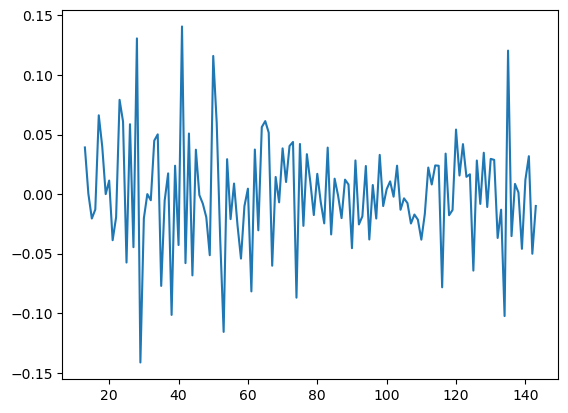

In [15]:
# 아래와 같은 데이터를 얻을 수 있음
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

### 5) 검정을 통해 정상성 확인하기

시계열 데이터가 정상적(stationary)인지 확인하는 방법이 ADF 검정법이다. p차 자기회귀모형의 단위근을 검정하는 하나의 방법이다.  
statsmodels.tsa.adfuller 패키지를 사용하면 쉽게 검증할 수 있다. adfuller 함수의 파라미터와 리턴값은 다음과 같다.  
(참고 : https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)  
- **Parameters:**  
x : 분석하고자 하는 시계열 데이터  
maxlag : {None, int}
Maximum lag which is included in test, default value of 12*(nobs/100)^{1/4} is used when None.  
regression : 가정하는 데이터 모형의 종류( 상수, 추세의 유무) (“c”,”ct”,”ctt”,”n”)  
autolag : {“AIC”, “BIC”, “t-stat”, None}  
lag length 자동 지정 (None 시 maxlag 에서 지정한 값 사용)  
store : bool, True일시 결과 인스턴스가 adf 통계량에 추가로 반환, 디폴트는 F.  
regresults : bool, optional, 참이면 전체 회귀 분석 결과가 반환. 디폴트는 F.


- **Returns:**  
adf : ADF 검정 통계량  
pvalue : P-value, 관찰된 데이터가 귀무가설이 맞다면 통계값 1이 실제로 관측된 값 이상일 확률   
usedlag : The number of lags used. 사용된 시차의 수.  
nobs : ADF 회귀 및 임계값 계산에 사용된 관측치의 수.    
critical values : 1%, 5% 및 10% 수준에서 테스트 통계에 대한 임계값.    
icbest :  0, 1, …, maxlag 값 중 lag 길이를 자동으로 결정할 때 autolag를 사용하며 이때   autolag를 none으로 지정할 수 있는데 none으로 지정하지 않는 경우 최대화된 정보 기준.  

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output
    print('ADF statistics')
    print(stat) # ADF 검정 통계량
    print('P-value')
    print(p_value) # P-value

In [17]:
adf_test(seasonally_diffed) # 계절차분까지 수행한 데이터에 대해 adf테스트를 수행

ADF statistics
-4.443324941831128
P-value
0.0002485912311383993


p-value는 귀무가설이 관찰된 데이터의 통계치(statistics)와 양립할 수 있는지를 0부터 1까지의 숫자로 나타낸다. 이 경우 귀무가설은 유의수준 0.01에서 단위근이 존재한다는 것이었으므로 귀무가설을 기각하고 대립가설, 즉 시계열은 정상적이라는 대립가설을 채택할 수 있다.

## 2. 모델 성능 상승 (시계열 분류)

### 1) 데이터 확인

In [18]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures #데이터 다운 및 불러오기

download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [19]:
timeseries # id, time을 제외하고 6개 column의 X변수가 나타남

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [20]:
y # true/false가 제시되어 있음

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

### 2) 데이터셋 가공 및 분리

In [21]:
def custom_classification_split(x,y,test_size=0.3):
    
    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    
    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = timeseries[~timeseries['id'].isin(id_list)] #코드해석
    X_test = timeseries[timeseries['id'].isin(id_list)]
    
    return X_train, y_train, X_test, y_test

In [22]:
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size = 0.25) #데이터 분리

특징 추출을 하는 데 많이 쓰이는 FCParameters로 MinimalFCParameters, ComprehensiveFCParamters, EfficientFCParameters가 있다.  그 중 큰 계산비용이 들어가는 calculator를 제외한 건 다 불러온다.

In [23]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

### 3) 특성 추출과 impute

In [24]:
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 37/37 [00:04<00:00,  8.50it/s]


In [25]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 32/32 [00:03<00:00, 10.32it/s]


In [26]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
impute(comprehensive_features_train)

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [27]:
impute(comprehensive_features_test)

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


### 4) 모델 성능 높이기

앙상블 모델을 적용하고, 더 많은 특징을 활용해서 분류 성능을 높이고자 했다.

In [28]:
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트 모델
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state=1004)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=1004)

In [29]:
rf_clf.score(comprehensive_features_test, y_test) 

0.9523809523809523

0.95? 이것은 랜덤 스테이트를 1004로 고정시 보이는 값이다. 반면 랜덤 스테이트가 600이면 0.42로 매우 낮은 값을 보인다. 그때그때마다 정확도가 많이 출렁이는 것을 확인할 수 있다. 

In [30]:
rf_clf2 = RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state=600)
rf_clf2.fit(comprehensive_features_train, y_train)
rf_clf2.score(comprehensive_features_test, y_test) 

0.42857142857142855

랜덤 포레스트 모델만으로는 정확도가 부족하다고 느껴서 다른 앙상블 모델을 불러와 테스트한다.

In [31]:
import xgboost as xgb #xgboost
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

xgb_clf.fit(comprehensive_features_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [32]:
xgb_clf.score(comprehensive_features_test, y_test)

1.0

plot_importance 함장 유의미한지수를 통해 어떤 x값이 이 결과를 분류하는 데 가장 중요한 역할을 했는지를 볼 수 있다. 즉, 가장 유의미한 변수(특징) 확인 가능.

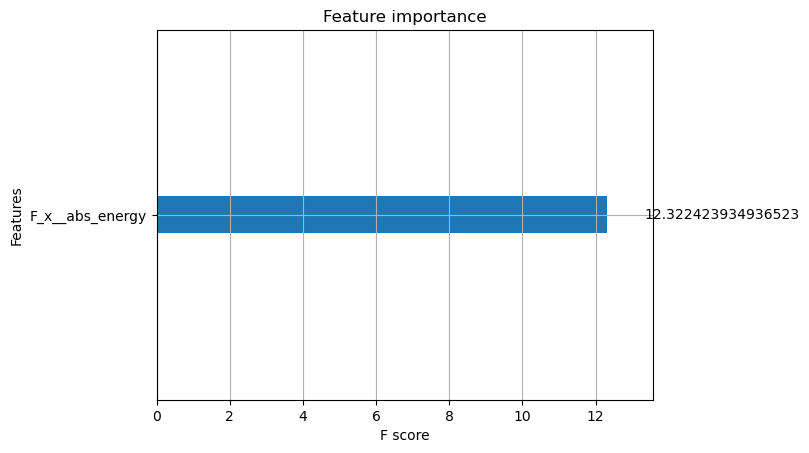

In [33]:
xgb.plot_importance(xgb_clf, importance_type = 'gain') # plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인
plt.show()

In [34]:
sum(xgb_clf.feature_importances_ != 0) # Fx값의 abs_energy특징만의 유의미함

1

중요도가 0이 아닌 피처가 absolute energy 하나밖에 없었다는 결과를 나타낸다. 즉 고장 유무를 판별하는 기준은 오직 F_x_abs_energy이다.

In [35]:
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True) # output_dict?
# classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'])

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

In [37]:
print(classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false']))

              precision    recall  f1-score   support

        true       1.00      1.00      1.00        16
       false       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



classification report를 통해 지표에서 설명하는 통계적인 수치가 각각 무엇인지 살펴보도록 한다.  
먼저 'true', 'false'라고 대답한 결과에 대해 각각 지표 precision, recall, f1-score, support가 존재한다. precision은 정밀도로 Positive라고 예측한 것 중에서 얼마나 잘 맞았는지 비율을 나타내며 recall은 실제 Positive한 것 중에서 얼마나 잘 예측하였는지 비율이다. F1 스코어는 리콜과 프리시젼의 조화평균이다. support는 각 레이블의 실제 샘플 개수이다.  
각 레이블의 평가지표를 평균해 보여주는 지표가 macro avg와 weighted avg로 표본 개수에 따른 가중치가 부여되었는지의 여부가 다르다.

## Discussion

- 차분을 할 때 첫번째 주기에 해당하는 값은 존재하지 않으므로 (1주기 이후부터 차분이 가능하니까) NaN 값으로 채워진다. 따라서 첫 주기의 NaN 값들을 drop 시켜 주어야 한다는 것을 잊지 말아야겠다고 생각했다.  

- 도메인 지식이 없이도 tsfresh를 이용해 특성추출을 정말 간편하게 할 수 있어서 감탄했다. 단 이렇게 특성 추출을 하고 난 후 적절한 모델을 선택하고 적절한 시각화 방법을 써서 유의미한 결과를 보여주는 것이 아직 자연스럽게 되지 않았고 각 단계별 일어나는 과정을 더 상세히 설명할 수 있어야 한다고 느꼈다.  

- 시간과 주기가 표시되어서 시간에 따른 데이터나 지표가 여러개가 나오는 경우가 많아서 그래프에서 각 축이 의미하는 것을 정확하게 알아야 한다고 느꼈다.

## References  

 - https://gaussian37.github.io/ml-concept-ml-evaluation/ (평가지표)  
 - https://zephyrus1111.tistory.com/169#c2 (adf 검정)
